In [61]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

In [62]:
A = 3 # left, stay, right
S = 2 # position and velocity in normalized space [0, 1]^2
p = 6 # order of kernel basis

# eta ~ (p, S)
eta = np.array([[0,1],[1,0],[1,1],[1,2],[2,0],[2,2]])

# w ~ (p, A)
w = np.random.normal(size=(p, A))
_w = np.ones((p, A))

# Q-function ~ (A,)
Q = lambda s: np.cos(np.pi * eta @ s).T @ w
# dQ-function ~ (p, A)
dQ = lambda s: np.cos(np.pi * eta @ s).reshape((p, 1)) * np.ones((1, A))

# hyper-parameters
gamma = 1.0 # \gamma
td = 0.75 # \lambda
alpha0 = 0.01/np.maximum(np.linalg.norm(eta, axis=1), 1).reshape(-1,1)
epsilon0 = 0.3

# epsilon-greedy policy
policy = lambda s, epsilon: np.argmax(Q(s)) if np.random.rand() > epsilon else np.random.randint(A)

100%|██████████| 200/200 [00:06<00:00, 30.58it/s]


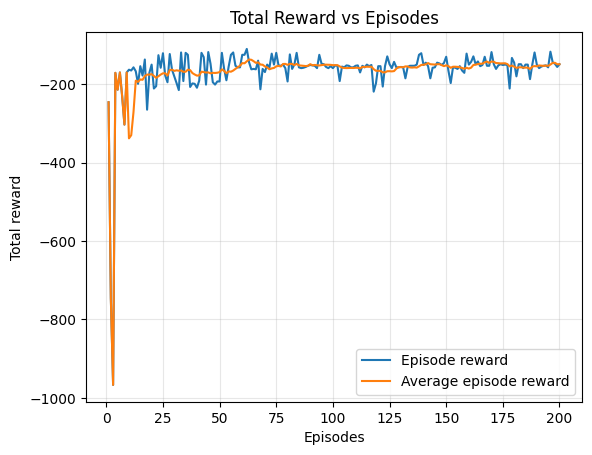

In [63]:
# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()
k = env.action_space.n      # tells you the number of actions
low, high = env.observation_space.low, env.observation_space.high

# Parameters
N_episodes = 200        # Number of episodes to run for training
discount_factor = 1.    # Value of gamma

# Reward
episode_reward_list = []  # Used to save episodes reward

# Functions used during training
def running_average(x, N):
    ''' Function used to compute the running mean
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def scale_state_variables(s, low=env.observation_space.low, high=env.observation_space.high):
    ''' Rescaling of s to the box [0,1]^2 '''
    x = (s - low) / (high - low)
    return x

# Training process
for i in tqdm(range(N_episodes)):
    # we use these
    epsilon = epsilon0 * np.exp(-0.5 * i / N_episodes)
    alpha = alpha0 * np.exp(-0.5 * i / N_episodes)
    eligibility_trace = np.zeros_like(w) # eligibility trace
    v = np.zeros_like(w) # acceleration term

    # Reset enviroment data
    done = False
    state, _ = env.reset()
    state = scale_state_variables(state)
    action = policy(state, epsilon)
    total_episode_reward = 0.

    while not done:
        # Get next state, reward and action. The done variable
        next_state, reward, done, _, _ = env.step(action)
        next_state = scale_state_variables(next_state)
        next_action = policy(next_state, epsilon)

        """ /SARSA """
        temporal_difference_error = reward + gamma * Q(next_state)[next_action] - Q(state)[action]
        eligibility_trace[:, action] += dQ(state)[:, action]
        eligibility_trace = np.clip(gamma * td * eligibility_trace, -5, 5)

        # update weights
        v = 0.4 * v + alpha * eligibility_trace * temporal_difference_error
        w += 0.4 * v + alpha * eligibility_trace * temporal_difference_error
        """ SARSA/ """

        # Update episode reward
        total_episode_reward += reward
            
        # Update state for next iteration
        state = next_state
        action = next_action

    # Append episode reward
    episode_reward_list.append(total_episode_reward)

    # Close environment
    env.close()


# Plot Rewards
plt.plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
plt.plot([i for i in range(1, N_episodes+1)], running_average(episode_reward_list, 10), label='Average episode reward')
plt.xlabel('Episodes')
plt.ylabel('Total reward')
plt.title('Total Reward vs Episodes')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [68]:
import pickle
data={'W':w.T, 'N':eta}
pickle.dump(data, open("weights.pkl", "wb"))

(3, 6) (6, 2)


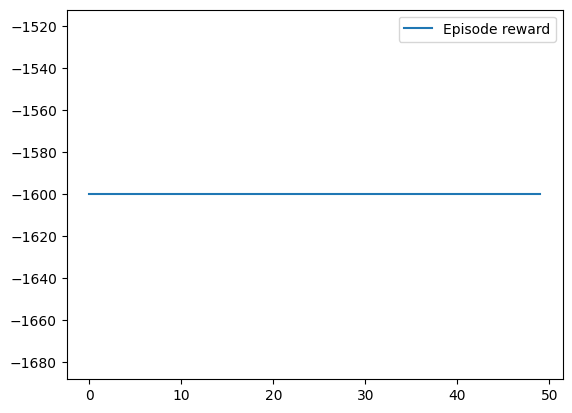

In [65]:
# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()
k = env.action_space.n      # tells you the number of actions
low, high = env.observation_space.low, env.observation_space.high

# Reward
episode_reward_list = []  # Used to save episodes reward

# Functions used during training
def running_average(x, N):
    ''' Function used to compute the running mean
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def scale_state_variables(s, low=env.observation_space.low, high=env.observation_space.high):
    ''' Rescaling of s to the box [0,1]^2 '''
    x = (s - low) / (high - low)
    return x

for _ in range(50):
    # Training process
    done = False
    state, _ = env.reset()
    state = scale_state_variables(state)
    total_episode_reward = 0.

    for _ in range(1600):
        # Get next state, reward and action. The done variable
        action = np.argmax(Q(state))
        next_state, reward, done, _, _ = env.step(action)
        next_state = scale_state_variables(next_state)

        # Update episode reward
        total_episode_reward += reward

        # Update state for next iteration
        state = next_state
        action = next_action
    episode_reward_list.append(total_episode_reward)

# Close environment
env.close()
    

plt.show()
# Plot Rewards
plt.plot(episode_reward_list, label='Episode reward')
plt.legend()